In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from skimage.metrics import structural_similarity as ssim


# Load the image
# image = cv2.imread("./IMG_20230710_102810.jpg")
image = cv2.imread("./IMG_20230709_212221.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply adaptive thresholding to binarize the image
plt.imshow(gray, cmap="gray")


In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

In [ ]:
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10)
plt.imshow(thresh, cmap= "gray")

In [ ]:
# Apply morphological operations to remove noise and fill gaps
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opening, cmap= "gray")


In [ ]:
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(closing, cmap= "gray")

In [6]:
# plt.imshow(kernel)
# Find the contours of the document
contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [7]:
# Sort the contours by area and keep only the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
# plt.imshow(contours)


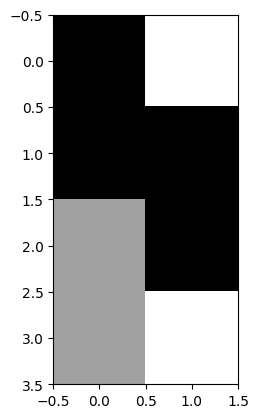

In [8]:
# Apply perspective transformation to "straighten" the image
rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect)
box = np.int0(box)
width = int(rect[1][0])
height = int(rect[1][1])
src_pts = box.astype("float32")
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
plt.imshow(dst_pts, cmap= "gray")
M = cv2.getPerspectiveTransform(src_pts, dst_pts)


In [ ]:
warped = cv2.warpPerspective(image, M, (width, height))
if warped.shape[0]>warped.shape[1]:
    warped=cv2.rotate(warped,cv2.ROTATE_90_CLOCKWISE)
plt.imshow(warped, cmap= "gray")

In [ ]:
# Apply image enhancement techniques to improve quality
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap= "gray")


In [ ]:
blurred = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(blurred, cmap= "gray")


In [ ]:
sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
plt.imshow(sharpened, cmap= "gray")

In [ ]:
denoised = cv2.fastNlMeansDenoising(sharpened, None, 10, 7, 21)
plt.imshow(denoised, cmap= "gray")

In [ ]:
# Save the resulting image
plt.imshow(denoised, cmap= "gray")
# cv2.imwrite("output.jpg", denoised)

In [ ]:
result=cv2.adaptiveThreshold(denoised,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,10)
plt.imshow(result, cmap= "gray")
# cv2.imwrite("./Thresh.jpg",result)

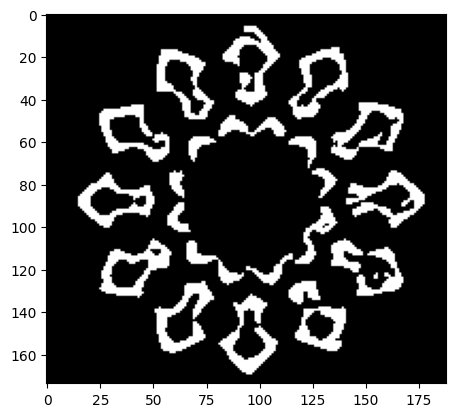

In [16]:
temp=cv2.imread("./fatemplates/melli_mark.png",cv2.IMREAD_GRAYSCALE)
temp=cv2.threshold(temp,128,255,cv2.THRESH_BINARY)[1]
w, h = temp.shape[::-1]
plt.imshow(temp, cmap= "gray")

In [17]:
res = cv2.matchTemplate(
            result, temp, cv2.TM_CCOEFF_NORMED)
maxi=np.max(res)
threshold=0.5
if maxi>threshold:
    print("Melli card: open melli.ipynb")
    loc = np.where(res >= threshold)
    output=warped.copy()
    for pt in zip(*loc[::-1]):
        cv2.rectangle(output, pt, (pt[0] + w, pt[1] + h), (255, 0, 0), 2)
    plt.imshow(output)
else:
    print("Bank card: open card.ipynb")

Bank card: open card.ipynb
